In [230]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report


import matplotlib.pyplot as plt


# Set random seed
seed = 0



In [231]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [232]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 8784 non-null   int64  
 1   budget                8784 non-null   int64  
 2   genres                8780 non-null   object 
 3   original_language     8784 non-null   object 
 4   overview              8784 non-null   object 
 5   popularity            8784 non-null   float64
 6   production_companies  8618 non-null   object 
 7   production_countries  8737 non-null   object 
 8   revenue               8784 non-null   int64  
 9   runtime               8784 non-null   float64
 10  spoken_languages      8768 non-null   object 
 11  status                8784 non-null   object 
 12  tagline               8784 non-null   object 
 13  video                 8784 non-null   int64  
 14  vote_average          8784 non-null   float64
 15  vote_count           

# Scoring prediction

In [233]:
df['video'].value_counts()

video
0    8778
1       6
Name: count, dtype: int64

In [234]:
# Get list of all unique names in df[`cast`]
df['cast'] = df['cast'].replace(np.nan, '')
unique_cast = df['cast'].str.split(',').explode()
unique_cast.value_counts()
# Take only actors that appeared in more than 10 movies
top_cast = unique_cast.value_counts()[unique_cast.value_counts() > 10]

df['cast'] = df['cast'].apply(lambda x: [i for i in x.split(',') if i in top_cast.index]).apply(lambda x: ','.join(x))
df['production_companies'] = df['production_companies'].replace(np.nan, '')
unique_production_companies = df['production_companies'].str.split(',').explode()
unique_production_companies.value_counts()

top_companies = unique_production_companies.value_counts()[unique_production_companies.value_counts() > 10]
df['production_companies'] = df['production_companies'].apply(lambda x: [i for i in x.split(',') if i in top_companies.index]).apply(lambda x: ','.join(x))
df['directors'] = df['directors'].replace(np.nan, '')
unique_directors = df['directors'].str.split(',').explode()
unique_directors.value_counts()

top_directors = unique_directors.value_counts()[unique_directors.value_counts() > 10]
df['directors'] = df['directors'].apply(lambda x: [i for i in x.split(',') if i in top_directors.index]).apply(lambda x: ','.join(x))
df['production_countries'] = df['production_countries'].replace(np.nan, '')
df['spoken_languages'] = df['spoken_languages'].replace(np.nan, '')
df['genres'] = df['genres'].replace(np.nan, '')
df['tagline'] = df['tagline'].replace(np.nan, '')
df['overview'] = df['overview'].replace(np.nan, '')

In [235]:
X = df.drop(columns=['vote_average', 'category'])
X = df.drop(columns=['video', 'adult', 'release_day'])
Y = df['category']


In [236]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Encode target variable (Y) using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


# Feature encoding

In [237]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                8784 non-null   int64  
 1   genres                8784 non-null   object 
 2   original_language     8784 non-null   object 
 3   overview              8784 non-null   object 
 4   popularity            8784 non-null   float64
 5   production_companies  8784 non-null   object 
 6   production_countries  8784 non-null   object 
 7   revenue               8784 non-null   int64  
 8   runtime               8784 non-null   float64
 9   spoken_languages      8784 non-null   object 
 10  status                8784 non-null   object 
 11  tagline               8784 non-null   object 
 12  vote_average          8784 non-null   float64
 13  vote_count            8784 non-null   float64
 14  cast                  8784 non-null   object 
 15  directors            

In [238]:
print(X.head())

      budget                                         genres original_language  \
0  200000000      Adventure,Action,Thriller,Science Fiction                en   
1  130000000               Science Fiction,Action,Adventure                en   
2  165000000               Action,Adventure,Science Fiction                en   
3  120000000               Action,Adventure,Science Fiction                en   
4   78000000  Fantasy,Action,Crime,Science Fiction,Thriller                en   

                                            overview  popularity  \
0  For centuries, a small but powerful force of w...      31.264   
1  One thousand years after cataclysmic events fo...      29.537   
2  We always knew they were coming back. Using re...      33.521   
3  Four young outsiders teleport to a dangerous u...      24.238   
4  He dwells in a world of eternal night, but the...      23.563   

                                production_companies  \
0  DC Entertainment,De Line Pictures,Warner Bros

In [242]:

numerical_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_count', 'release_year', 'release_month']
categorical_features = ['original_language', 'status']
boolean_features = ['adult', 'video']
text_features = ['overview', 'tagline', 'title']
list_based_features = ['genres', 'production_companies', 'production_countries', 'cast', 'directors']

# 1. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# 3. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# 4. Text transformer: Use TF-IDF for text columns
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))  # Adjust max_features as needed
])

# 5. List-based transformer: Convert list of items into count vectors (like multi-hot encoding)
def list_to_str(column):
    return column.apply(lambda x: ','.join(x) if isinstance(x, list) else '')

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        # ('bool', boolean_transformer, boolean_features),
        ('overview', text_transformer, 'overview'),
        ('tagline', text_transformer, 'tagline'),
        ('genres', text_transformer, 'genres'),
        ('production_companies', text_transformer, 'production_companies'),
        ('production_countries', text_transformer, 'production_countries'),
        ('cast', text_transformer, 'cast'),
        ('directors', text_transformer, 'directors')
    ]
)

In [243]:
X_train_encoded = preprocessor.fit_transform(X_train)
print(X_train_encoded)


# 1. Obter as colunas numéricas após a transformação
numerical_columns = numerical_features  # Os nomes permanecem os mesmos

# 2. Obter as colunas categóricas após a codificação one-hot
categorical_columns = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# 3. Colunas de texto após TF-IDF
overview_columns = preprocessor.named_transformers_['overview'].get_feature_names_out(['overview'])
tagline_columns = preprocessor.named_transformers_['tagline'].get_feature_names_out(['tagline'])
genres_columns = preprocessor.named_transformers_['genres'].get_feature_names_out(['genres'])
production_companies_columns = preprocessor.named_transformers_['production_companies'].get_feature_names_out(['production_companies'])
production_countries_columns = preprocessor.named_transformers_['production_countries'].get_feature_names_out(['production_countries'])
cast_columns = preprocessor.named_transformers_['cast'].get_feature_names_out(['cast'])
directors_columns = preprocessor.named_transformers_['directors'].get_feature_names_out(['directors'])

# 4. Combinar todas as colunas
features = np.concatenate([
    numerical_columns, 
    categorical_columns, 
    overview_columns, 
    tagline_columns,
    genres_columns,
    production_companies_columns,
    production_countries_columns,
    cast_columns,
    directors_columns
])

# Agora você pode usar `all_columns` como a lista de nomes das features
print(features)


X_train_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_train_encoded, columns=features)
print(X_train_encoded_df)

X_test_encoded = preprocessor.transform(X_test)  #Just transform, not fit so they have the same number of features
print(X_test_encoded)

  (0, 0)	-0.08619960335899651
  (0, 1)	-0.18237344551555748
  (0, 2)	0.08345800497584235
  (0, 3)	-0.5505827317471977
  (0, 4)	1.795802171379134
  (0, 5)	0.42331317103209676
  (0, 6)	1.2175666622553376
  (0, 15)	1.0
  (0, 42)	1.0
  (0, 116)	0.5864674656785438
  (0, 124)	0.5226236148284815
  (0, 130)	0.6188056794537337
  (0, 198)	1.0
  (0, 244)	0.6937175157199655
  (0, 249)	0.46303948736614914
  (0, 260)	0.5516796548025068
  (0, 273)	0.28120239791970725
  (0, 299)	0.43938915948487495
  (0, 302)	0.29381623162362774
  (0, 329)	0.440833707193948
  (0, 331)	0.33524861148923174
  (0, 333)	0.2608753051066312
  (0, 343)	0.4338761288913083
  (0, 360)	0.28018563672299496
  (0, 367)	0.302264718805644
  :	:
  (7025, 452)	0.2912134271980113
  (7025, 461)	0.27482428700138295
  (7026, 0)	0.1793668052887353
  (7026, 1)	-0.1509840149906671
  (7026, 2)	-0.12953782644463857
  (7026, 3)	-1.1135691250570259
  (7026, 4)	-0.07500471776376888
  (7026, 5)	0.4843423180098479
  (7026, 6)	0.34449197240177887
  (7

In [244]:
print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")


X_train_encoded shape: (7027, 664)
X_test_encoded shape: (1757, 664)


# Transparent Models

## Decision Tree

### C45 Algorithm

Functions needed to help calculate the Information Gain Ratio to be used with the tree. Attention for being a Multi-class Classification problem (4 possible values).


In [245]:
# lower values are better = more purity
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    probabilities = counts / np.sum(counts) 
    entropy_value = -np.sum(probabilities * np.log2(probabilities + 1e-9)) 

    return entropy_value

In [246]:
# 'category' has 4 possible values, so Entropy can range from 0 (perfectly pure, all values in one class) to 2 (all classes represented equally in the same number each)
e = entropy(df['category'])
elements, counts = np.unique(df['category'], return_counts=True)
print(e)
print(elements)
print(counts)

1.9999999942292197
['bad' 'good' 'great' 'mediocre']
[2196 2196 2196 2196]


In [247]:
def info_gain(data, split_attribute_name, target_name='category'):
    total_entropy = entropy(data[target_name])
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    
    weighted_entropy = 0
    for i in range(len(values)):
        subset = data[data[split_attribute_name].astype(str) == values[i]]  
        subset_entropy = entropy(subset[target_name])  
        weighted_entropy += (counts[i] / np.sum(counts)) * subset_entropy  
    
    return total_entropy - weighted_entropy

In [248]:
#fake_data = {
 #   'feature1': ['A', 'A', 'B', 'B', 'A', 'B', 'A', 'A', 'B', 'B'],
  #  'feature2': ['X', 'X', 'X', 'Y', 'Y', 'Y', 'X', 'Y', 'X', 'Y'],
   # 'category': ['yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'no']
#}
#df_tester = pd.DataFrame(fake_data)

# Test the function
#total_entropy = entropy(df_tester['category'])
#print("Total Entropy:", total_entropy)

# Calculate information gain for 'feature1'
#ig_feature1 = info_gain(df_tester, 'feature1', target_name='category')
#print("Information Gain for feature1:", ig_feature1)

# Calculate information gain for 'feature2'
#ig_feature2 = info_gain(df_tester, 'feature2', target_name='category')
#print("Information Gain for feature2:", ig_feature2)



In [249]:
# Reescrevendo a função para aceitar DataFrame
def info_gain_ratio(data, split_attribute_name, target_name='category'):
    information_gain = info_gain(data, split_attribute_name, target_name)
    
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    split_information = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(values))])
    
    if split_information == 0:
        return 0
    return information_gain / split_information

In [250]:
# Test the function
#ig_ratio_feature1 = info_gain_ratio(df_tester, 'feature1', target_name='category')
#print("Information Gain Ratio for feature1:", ig_ratio_feature1)

#ig_ratio_feature2 = info_gain_ratio(df_tester, 'feature2', target_name='category')
#print("Information Gain Ratio for feature2:", ig_ratio_feature2)


In [251]:
from scipy.sparse import issparse

# Assume entropy and info_gain_ratio functions are already defined

def c45(X, Y, features, parent_class=None):
    # Convert Y to a Pandas Series for compatibility
    Y = pd.Series(Y)

    # If X is a sparse matrix, convert it to a dense DataFrame
    if issparse(X):
        X = pd.DataFrame(X.toarray(), columns=features)

    # Base case 1: All samples belong to the same class
    if len(Y.unique()) == 1:
        return Y.iloc[0]  # Return the class label

    # Base case 2: None of the features provide any information gain
    information_gains = [info_gain_ratio(X, feature, target_name='category') for feature in features]

    if all(gain == 0 for gain in information_gains):
        # Return the expected value (majority class)
        return Y.mode()[0]  # Returns the most frequent class label

    # Check for unseen classes
    unique_classes = Y.unique()
    
    # If there is a class not in the unique classes, return the expected value
    if parent_class is not None and parent_class not in unique_classes:
        return Y.mode()[0]  # Return the most frequent class label as expected value

    # Step 2: Find the best attribute to split on
    best_feature_index = np.argmax(information_gains)  # Get the index of the best feature
    best_feature = features[best_feature_index]  # The best feature name
    
    # Step 3: Create a decision node that splits on best_feature
    tree = {best_feature: {}}

    # Split the dataset by the best feature and create subtrees recursively
    for value in X[best_feature].unique():
        subset_X = X[X[best_feature] == value].drop(columns=best_feature)  # Subset for features
        subset_Y = Y[X[best_feature] == value]  # Corresponding target values
        
        # Recursively build the subtree
        subtree = c45(subset_X, subset_Y, features, parent_class=Y.mode()[0])
        tree[best_feature][value] = subtree  # Add the subtree to the tree

    return tree  # Return the constructed tree

In [252]:

# Call the c45 function
#leaf_node = c45(df_tester, target_name='category', features=['feature1', 'feature2'])
#print("Leaf Node:", leaf_node)  # Output should be 'yes'


In [253]:
#unseen_class = 'maybe'
#leaf_node = c45(df_tester, target_name='category', features=['feature1', 'feature2'], parent_class=unseen_class)
#print("Leaf Node for Unseen Class:", leaf_node)

In [254]:
def predict(tree, instance,target_name, data):
    # If the tree is a leaf node, return the class label
    if isinstance(tree, str):  # Leaf node check (if it's a string)
        return tree
    
    # Extract the attribute to split on
    attribute = list(tree.keys())[0]
    subtree = tree[attribute]
    
    # Get the attribute value for the current instance
    value = instance[attribute]
    
    # Check if the attribute value exists in the subtree
    if value in subtree:
        # Recurse on the subtree
        return predict(subtree[value], instance, target_name, data)
    else:
        # If the attribute value is not found, return the expected value (majority class)
        return data[target_name].mode()[0]  # Return the mode of the target class


In [258]:
# Calcular ganho de informação para cada feature
X_train_encoded_df['category'] = Y_train_encoded


In [262]:
X_train_encoded_df = X_train_encoded_df.loc[:, ~X_train_encoded_df.columns.duplicated()]


In [263]:
print(X_train_encoded_df.columns.duplicated())


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [265]:
c45tree = c45(X_train_encoded_df, Y_train_encoded, features)

KeyboardInterrupt: 

In [ ]:
Y_pred = (predict(c45tree, sample, 'category', X_test_encoded) for _, sample in X_test.iterrows())


In [149]:
Y_pred = list(Y_pred)

In [150]:
print(Y_pred)

['bad', 'good', 'mediocre', 'bad', 'great', 'good', 'great', 'mediocre', 'great', 'good', 'great', 'mediocre', 'mediocre', 'mediocre', 'good', 'good', 'bad', 'good', 'mediocre', 'bad', 'bad', 'mediocre', 'good', 'mediocre', 'great', 'mediocre', 'good', 'great', 'mediocre', 'good', 'mediocre', 'great', 'mediocre', 'mediocre', 'good', 'mediocre', 'mediocre', 'bad', 'bad', 'good', 'mediocre', 'good', 'bad', 'mediocre', 'bad', 'bad', 'bad', 'bad', 'bad', 'mediocre', 'good', 'bad', 'great', 'bad', 'bad', 'mediocre', 'mediocre', 'great', 'good', 'great', 'good', 'mediocre', 'mediocre', 'great', 'good', 'good', 'mediocre', 'great', 'good', 'bad', 'mediocre', 'good', 'mediocre', 'good', 'bad', 'great', 'bad', 'mediocre', 'great', 'bad', 'great', 'great', 'good', 'bad', 'mediocre', 'bad', 'great', 'good', 'great', 'mediocre', 'mediocre', 'great', 'bad', 'bad', 'good', 'great', 'mediocre', 'good', 'bad', 'bad', 'mediocre', 'great', 'mediocre', 'mediocre', 'bad', 'great', 'mediocre', 'bad', 'good

In [151]:
accuracy = accuracy_score(Y_test, Y_pred)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 1.0000


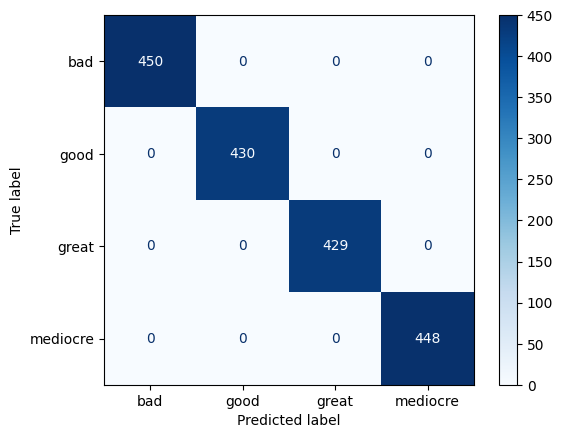

In [153]:
# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
